# <center> ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА

### Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.  

Ключевые вопросы HR-агентства:

* Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?  
* Какие факторы влияют на зарплату у специалистов Data Scientist?  
* Как соотносятся зарплаты Data Scientist и Data Engineer в различных компаниях?  
* Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании? 

### Загрузка данных

In [1]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [2]:
# загружаем датасет
ds_salaries = pd.read_csv('ds_salaries.csv')
ds_salaries.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [3]:
ds_salaries = ds_salaries.drop('Unnamed: 0', axis = 1)

### Описание данных

* **work_year** - Год выплаты зарплаты
* **experience_level** - Уровень опыта работы в течение года со следующими возможными значениями:   
                                                                                            EN Начальный уровень   
                                                                                            Младший MI Средний уровень   
                                                                                            Промежуточный SE Старший уровень   
                                                                                            Эксперт EX Исполнительный уровень Директор   
* **employment_type** - Тип занятости для должности:   
PT Неполный рабочий день   
                                                 FT Полная занятость   
                                                 CT Контракт   
                                                 FL Внештатный  
* **job_title** - Роль отрабатывалась в течение года
* **salary** - Общая сумма выплаченной брутто-зарплаты
* **salary_currency** - Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217
* **salary_in_usd** - Заработная плата в долларах США (курс валюты, разделенный на средний курс доллара США за соответствующий год через fxdata.foorilla.com)
* **employee_residence** - Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166
* **remote_ratio** - Общий объем удаленной работы, возможные значения:   
0 Нет удаленной работы (менее 20%)   
                                                                   50 Частично удаленная работа   
                                                                   100 Полностью удаленная работа (более 80%)  
* **company_location** - Страна главного офиса или филиала работодателя в виде кода страны ISO 3166
* **company_size** - Среднее количество людей, работавших в компании в течение года: S менее 50 сотрудников (малое) M от 50 до 250 сотрудников (среднее) L более 250 сотрудников (крупное)

### Описательный анализ данных

In [4]:
ds_salaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 52.3+ KB


Данные содержат 607 строк, пропущенных значений нет.  

**work_year** категориальный признак, представлен в числовом формате  
**experience_leve**l категориальный признак, представлен в текстовом формате  
**employment_type** категориальный признак, представлен в текстовом формате  
**job_title** не признак  
**salary** количественный признак, представлен в числовом формате, скорее всего не будет участвовать в анализе, т.к. представлен этот же признак приведенный в одних единицах измерения   
**salary_currency** не признак   
**salary_in_usd** количественный признак, представлен в числовом формате  
**employee_residence** категориальный признак, представлен в текстовом формате  
**remote_ratio** категориальный признак, представлен в числовом формате  
**company_location** категориальный признак, представлен в текстовом формате  
**company_size** категориальный признак, представлен в текстовом формате

In [5]:
# проверяем на наличие дубликатов

print('Количество дубликатов: {}'.format(ds_salaries[ds_salaries.duplicated()].shape[0]))

Количество дубликатов: 42


In [6]:
DS = ds_salaries[ds_salaries['job_title'] == 'Data Scientist'] # выделим специалистов Data Scientist в отдельный датасет

## Визуализация гипотез

### 1. Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

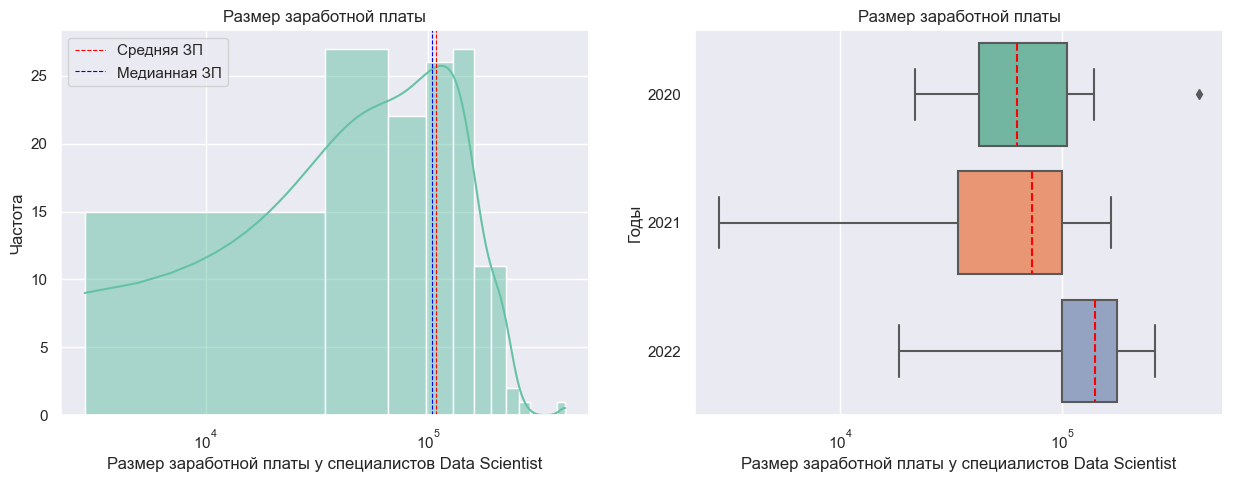

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(DS['salary_in_usd'], 
             kde=True,
             ax=axes[0])
axes[0].set(xlabel='Размер заработной платы у специалистов Data Scientist', 
            ylabel='Частота')
axes[0].set_title('Размер заработной платы')

axes[0].axvline(DS['salary_in_usd'].mean(), 
                color='red', 
                linestyle='--', 
                linewidth=0.8, 
                label='Средняя ЗП')

axes[0].axvline(DS['salary_in_usd'].median(), 
                color='blue', 
                linestyle='--', 
                linewidth=0.8, 
                label='Медианная ЗП')

axes[0].set(xscale="log")
axes[0].legend(loc='upper left')

sns.boxplot(DS, 
            x = 'salary_in_usd', 
            y = 'work_year', 
            orient='h', 
            medianprops={"color": "red", "linestyle": '--'})

axes[1].set_title('Размер заработной платы')
axes[1].set(xscale="log")
axes[1].set(xlabel='Размер заработной платы у специалистов Data Scientist', 
            ylabel= 'Годы')
plt.show()

In [8]:
DS_agg = DS.groupby('work_year')['salary_in_usd'].describe().round(2)
print('Размер заработной платы у специалистов Data Scientist в динамике')
DS_agg

Размер заработной платы у специалистов Data Scientist в динамике


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,21.0,85970.52,81436.65,21669.0,42197.0,62726.0,105000.0,412000.0
2021,45.0,70671.73,45422.97,2859.0,33808.0,73000.0,100000.0,165000.0
2022,77.0,136172.09,54563.08,18442.0,100000.0,140000.0,176000.0,260000.0


В качестве анализируемого признака выбрана заработная плата в долларах США, т.к. данный признак не зависит от валюты, в которой специалист получает заработную плату и имеет единую структуру.  
Распределение размера заработной платы имеет распределение близкое к нормальному, значение средней и медианой заработной платы находятся близко друг к другу.  
Боксплот, построенный в динамике, указывает на общую тенедецию роста медианной заработной платы у специалистов Data Scientist, т.е. можем предположить о наличии статистически значимой связи. При этом наибольший размах вариации в зарплатах наблюдался в 2021 году. Скорее всего это связано с мировой геополитической ситуацией, перераспределением рынка специалистов и средняя заработная плата в 2021 году меньше, чем в 2020 году.  

### 2. Какие факторы влияют на зарплату у специалистов Data Scientist?

#### 2.1 Соотношение уровня опыта работы и размера заработной платы

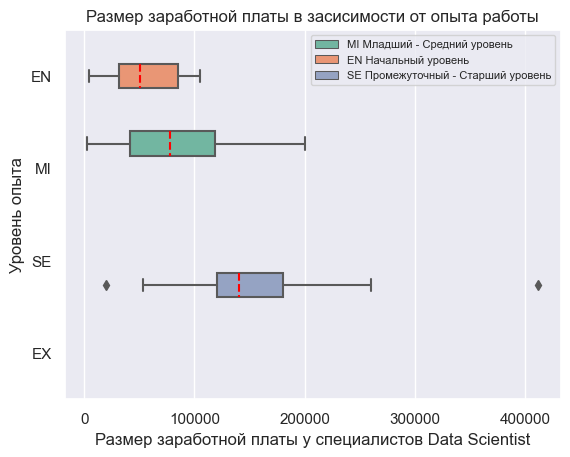

In [9]:
f = sns.boxplot(DS, 
            x = 'salary_in_usd', 
            y = 'experience_level',
            order=["EN", "MI", "SE", "EX"],    
            orient='h', 
            medianprops={"color": "red", "linestyle": '--'},
            hue="experience_level")
            
f.set_title('Размер заработной платы в засисимости от опыта работы')

f.set(xlabel='Размер заработной платы у специалистов Data Scientist', 
      ylabel= 'Уровень опыта')

legend_label = ["MI Младший - Средний уровень", "EN Начальный уровень", "SE Промежуточный - Старший уровень"] # , "EX Эксперт - Исполнительный уровень, Директор" нет в выборке
f.legend(title="Уровень опыта")
f.legend(loc='upper right', fontsize=8)

n = 0
for i in legend_label:
    f.legend_.texts[n].set_text(i)
    n += 1
    
plt.show()

In [10]:
DS_agg = DS.groupby('experience_level')['salary_in_usd'].describe().round(2)
print('Размер заработной платы у специалистов Data Scientist в зависимости от опыта')
DS_agg

Размер заработной платы у специалистов Data Scientist в зависимости от опыта


,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,22.0,55330.91,31237.82,4000.0,31474.0,50483.5,85027.25,105000.0
MI,60.0,82039.13,46869.58,2859.0,41768.0,77479.0,118264.75,200000.0
SE,61.0,152971.02,58985.40,20171.0,120000.0,140400.0,180000.00,412000.0


Распределение заработной платы у специалистов Data Scientist указывает на наличие взаимосвязи между уровнем опыта и размером заработной платы.  
Исполнительный уровень в выборке отсутствует.

#### 2.2 Соотношение типа занятости и размера заработной платы

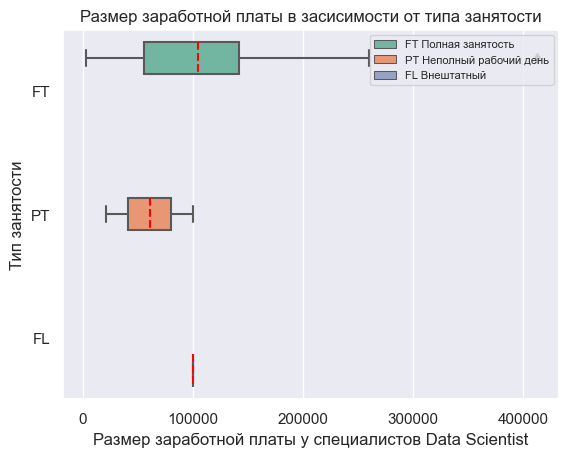

In [11]:
f = sns.boxplot(DS, 
            x = 'salary_in_usd', 
            y = 'employment_type', 
            orient='h', 
            medianprops={"color": "red", "linestyle": '--'},
            hue="employment_type")
            
f.set_title('Размер заработной платы в засисимости от типа занятости')

f.set(xlabel='Размер заработной платы у специалистов Data Scientist', 
      ylabel= 'Тип занятости')

legend_label = ["FT Полная занятость", "PT Неполный рабочий день", "FL Внештатный"] #  "CT Контракт",
f.legend(title="Тип занятости")
f.legend(loc='upper right', fontsize=8)

n = 0
for i in legend_label:
    f.legend_.texts[n].set_text(i)
    n += 1
    
plt.show()

In [12]:
DS_agg = DS.groupby('employment_type')['salary_in_usd'].describe().round(2)
print('Размер заработной платы у специалистов Data Scientist в зависимости от типа занятости')
DS_agg

Размер заработной платы у специалистов Data Scientist в зависимости от типа занятости


,count,mean,std,min,25%,50%,75%,max
employment_type,,,,,,,,
FL,1.0,100000.00,NaN,100000.0,100000.00,100000.0,100000.00,100000.0
FT,140.0,108922.79,64372.43,2859.0,55490.00,104796.0,141975.00,412000.0
PT,2.0,60834.50,55388.38,21669.0,41251.75,60834.5,80417.25,100000.0


В выборке отсутствуют специалисты Data Scientist, работающие на условиях контракта. В качестве внештатного работника в выборке присутствует только 1 специалист, на условиях неполного рабочего дня 2 специалиста. Таким образом трудно сказать существует ли статистически значимая связь заработной платы специалистов Data Scientist с типом занятости.  
Поскольку 2 из 3 групп слишком малы для проведения статистических тестов, данная гипотеза рассматриваться не будет.

#### 2.3 Соотношение страны головного офиса и размера заработной платы

In [13]:
DS1 = DS.copy()

In [14]:
def get_city(city):                          
    
    country_list = ['US', 'GB', 'IN', 'FR', 'DE', 'CA'] # выбираем страны, в которых работает более 5 специалистов
    
    if city in country_list:         # если город в списке
        return city                  # возвращаем его название
    else:  
        return 'other'               # в остальных случаях другие
    
DS1['employee_residence'] = DS1['employee_residence'].apply(get_city).astype('category')

In [15]:
DS1['company_location'] = DS1['company_location'].apply(get_city).astype('category')

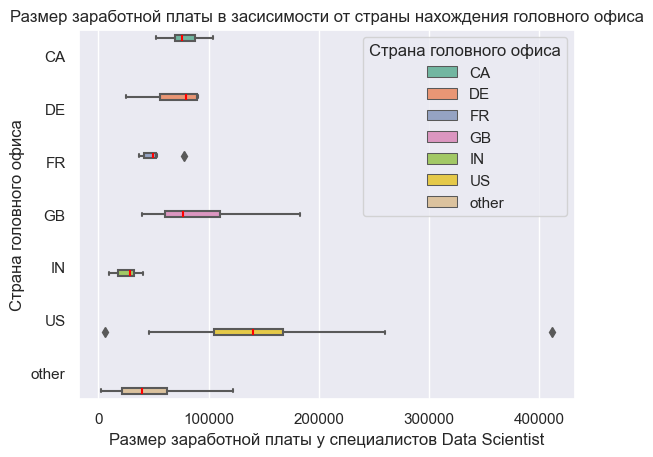

In [16]:
f = sns.boxplot(DS1, 
            x = 'salary_in_usd', 
            y = 'company_location', 
            orient='h', 
            medianprops={"color": "red", "linestyle": '--'},
            hue="company_location")
            
f.set_title('Размер заработной платы в засисимости от страны нахождения головного офиса')

f.set(xlabel='Размер заработной платы у специалистов Data Scientist', 
      ylabel= 'Страна головного офиса')
f.legend(title="Страна головного офиса")
plt.show()

In [17]:
DS_agg = DS1.groupby('company_location')['salary_in_usd'].describe().round(2)
print('Размер заработной платы в засисимости от страны нахождения головного офиса')
DS_agg

Размер заработной платы в засисимости от страны нахождения головного офиса


,count,mean,std,min,25%,50%,75%,max
company_location,,,,,,,,
CA,5.0,77787.00,19301.65,52396.0,69336.0,75774.0,87738.00,103691.0
DE,7.0,69640.14,25045.56,25532.0,55997.0,79833.0,89694.00,90734.0
FR,7.0,50085.57,13658.91,36643.0,41056.5,49646.0,52256.50,77684.0
GB,11.0,88177.36,41393.50,39263.0,60847.0,76958.0,110808.00,183228.0
IN,8.0,26108.25,10248.05,9466.0,18057.5,29075.0,32163.25,40481.0
US,84.0,143115.68,56252.98,5679.0,105000.0,140000.0,167750.00,412000.0
other,21.0,49681.48,35695.49,2859.0,21669.0,40000.0,62726.00,122346.0


CA - Канада  
DE - Германия  
FR - Франция  
GB - Великобритании  
IN - Индия  
US - США  
Можно сделать вывод, что существует статистически значимая взаимосвязь между страной нахождения головного офиса и уровнем заработной платы.

#### 2.4 Соотношение страны проживания специалиста и размера заработной платы

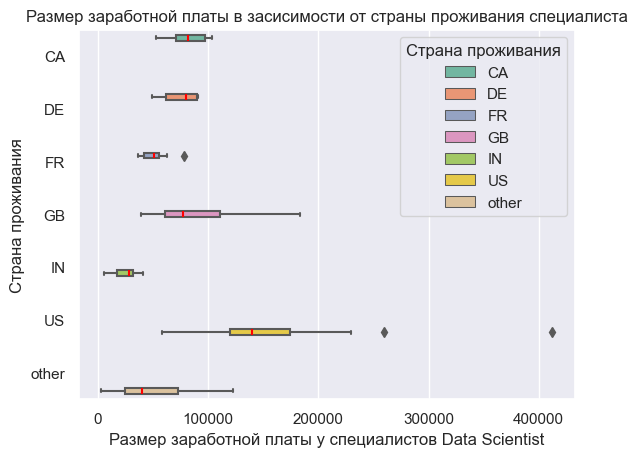

In [18]:
f = sns.boxplot(DS1, 
            x = 'salary_in_usd', 
            y = 'employee_residence', 
            orient='h', 
            medianprops={"color": "red", "linestyle": '--'},
            hue="employee_residence")
            
f.set_title('Размер заработной платы в засисимости от страны проживания специалиста')

f.set(xlabel='Размер заработной платы у специалистов Data Scientist', 
      ylabel= 'Страна проживания')
f.legend(title="Страна проживания")
plt.show()

In [19]:
DS_agg = DS1.groupby('employee_residence')['salary_in_usd'].describe().round(2)
print('Размер заработной платы в засисимости от страны нахождения головного офиса')
DS_agg

Размер заработной платы в засисимости от страны нахождения головного офиса


,count,mean,std,min,25%,50%,75%,max
employee_residence,,,,,,,,
CA,6.0,81489.17,19500.74,52396.0,70945.50,81756.0,96934.50,103691.0
DE,7.0,74773.71,16834.87,49268.0,62096.50,79833.0,89694.00,90734.0
FR,8.0,51665.62,13412.16,36643.0,41626.75,50483.5,55575.50,77684.0
GB,11.0,88177.36,41393.50,39263.0,60847.00,76958.0,110808.00,183228.0
IN,9.0,23838.33,11758.72,5679.0,16904.00,28399.0,31615.00,40481.0
US,78.0,149408.33,52576.02,58000.0,120000.00,140000.0,174500.00,412000.0
other,24.0,50284.92,35294.01,2859.0,24566.25,40019.0,72996.75,122346.0


CA - Канада    
DE - Германия    
FR - Франция    
GB - Великобритании  
IN - Индия   
US - США   
Можно сделать вывод, что существует статистически значимая взаимосвязь между страной проживания и уровнем заработной платы. 

#### 2.5 Соотношение объема удаленной работы и размера заработной платы

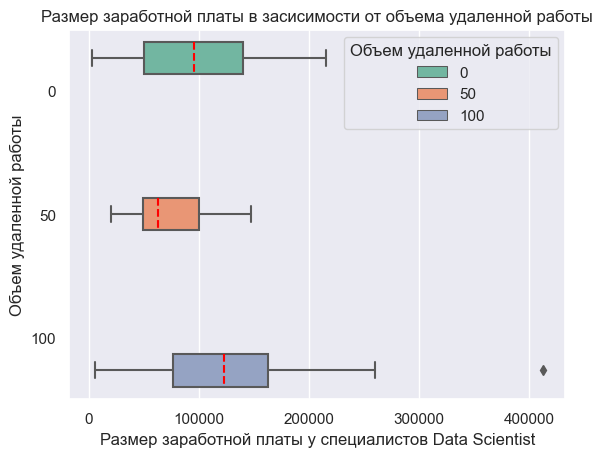

In [20]:
f = sns.boxplot(DS, 
            x = 'salary_in_usd', 
            y = 'remote_ratio', 
            orient='h', 
            medianprops={"color": "red", "linestyle": '--'},
            hue="remote_ratio")
            
f.set_title('Размер заработной платы в засисимости от объема удаленной работы')

f.set(xlabel='Размер заработной платы у специалистов Data Scientist', 
      ylabel= 'Объем удаленной работы')

f.legend(title="Объем удаленной работы")
    
plt.show()

In [21]:
DS_agg = DS.groupby('remote_ratio')['salary_in_usd'].describe().round(2)
print('Размер заработной платы в засисимости от страны нахождения головного офиса')
DS_agg

Размер заработной платы в засисимости от страны нахождения головного офиса


,count,mean,std,min,25%,50%,75%,max
remote_ratio,,,,,,,,
0,39.0,99520.74,58259.42,2859.0,50294.5,95550.0,140400.0,215300.0
50,25.0,74504.08,35602.82,20171.0,49646.0,62726.0,100000.0,147000.0
100,79.0,123125.94,69370.99,5679.0,76366.0,123000.0,162500.0,412000.0


Коробки при разном уровне удаленной работы имеют различный размах вариации значений, т.е. можем предположить о наличии статистически значимой связи между объемом удаленной работы и заработной платой у специалистов Data Scientist существует статистически значимая взаимосвязь. Но при этом четкой направленности этой связи визуально выявить не представляется возможным.

#### 2.6 Соотношение размера компании и размера заработной платы

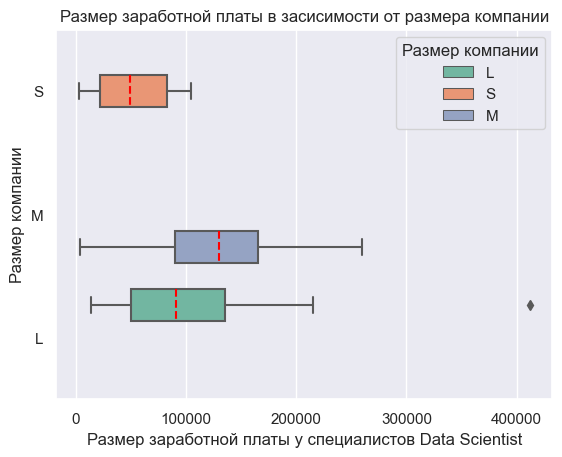

In [22]:
f = sns.boxplot(DS, 
            x = 'salary_in_usd', 
            y = 'company_size',
            order=["S", "M", "L"],
            orient='h', 
            medianprops={"color": "red", "linestyle": '--'},
            hue="company_size")
            
f.set_title('Размер заработной платы в засисимости от размера компании')

f.set(xlabel='Размер заработной платы у специалистов Data Scientist', 
      ylabel= 'Размер компании')

f.legend(title="Размер компании")
    
plt.show()

In [23]:
DS_agg = DS.groupby('company_size')['salary_in_usd'].describe().round(2)
print('Размер заработной платы в засисимости от размера компании')
DS_agg

Размер заработной платы в засисимости от размера компании


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,45.0,103313.36,71815.18,13400.0,50000.0,90734.0,135000.0,412000.0
M,77.0,126380.75,56389.53,4000.0,90000.0,130000.0,165000.0,260000.0
S,21.0,51925.76,33216.29,2859.0,21669.0,49268.0,82500.0,105000.0


Коробки при разном размере компании имеют различный размах вариации значений, т.е. можем предположить о наличии статистически значимой связи между размером компании и заработной платой у специалистов Data Scientist. При этом направленность связи не очевидна.

### 3. Как соотносятся зарплаты Data Scientist и Data Engineer в различных компаниях?

#### 3.1 в зависимости от места нахождения головного офиса компании

In [24]:
DS_DE = ds_salaries[(ds_salaries['job_title'] == 'Data Scientist') | (ds_salaries['job_title'] == 'Data Engineer')] # выделим специалистов Data Scientist и Data Engineer в отдельный датасет

In [25]:
DS_DE1 = DS_DE.copy()

In [26]:
def get_city2(city):                          
    
    country_list = ['US', 'GB', 'IN', 'FR', 'DE', 'ES'] # выбираем страны, в которых работает более 5 специалистов, СА и GR исключены, т.е. в них не представлены обе профессии
    
    if city in country_list:         # если город в списке
        return city                  # возвращаем его название
    else:  
        return 'other'               # в остальных случаях другие
    
DS_DE1['company_location'] = DS_DE1['company_location'].apply(get_city2).astype('category')

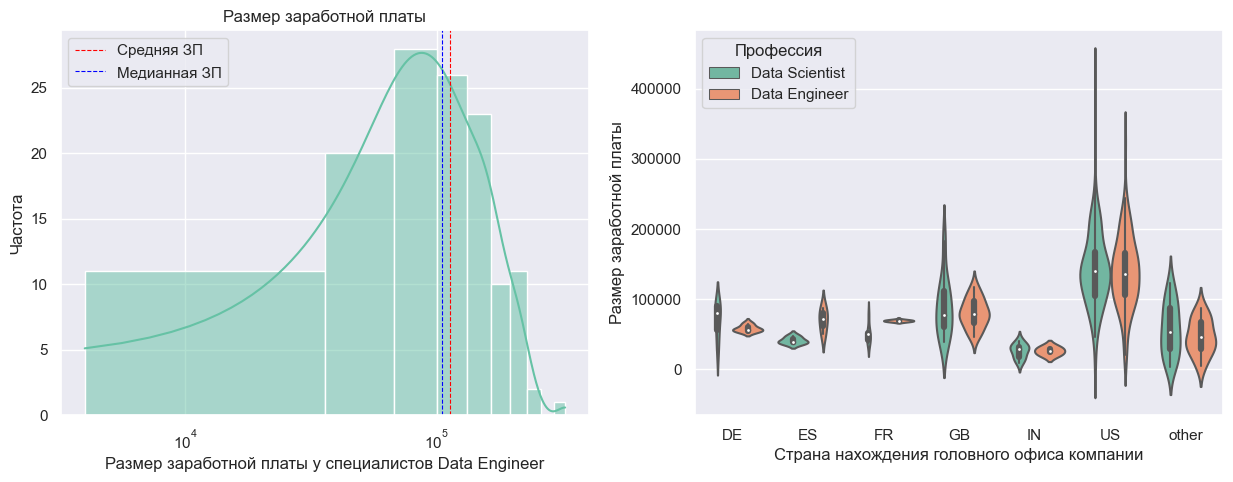

In [27]:
DS_DE2 = DS_DE1[DS_DE1['job_title'] == 'Data Engineer']

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(DS_DE2['salary_in_usd'], 
             kde=True,
             ax=axes[0])
axes[0].set(xlabel='Размер заработной платы у специалистов Data Engineer', 
            ylabel='Частота')
axes[0].set_title('Размер заработной платы')

axes[0].axvline(DS_DE2['salary_in_usd'].mean(), 
                color='red', 
                linestyle='--', 
                linewidth=0.8, 
                label='Средняя ЗП')

axes[0].axvline(DS_DE2['salary_in_usd'].median(), 
                color='blue', 
                linestyle='--', 
                linewidth=0.8, 
                label='Медианная ЗП')

axes[0].set(xscale="log")
axes[0].legend(loc='upper left')

sns.violinplot(data = DS_DE1, 
               x = 'company_location', 
               y = 'salary_in_usd', 
               hue = 'job_title')

axes[1].legend(title="Профессия", loc='upper left')
axes[1].set(xlabel='Страна нахождения головного офиса компании', 
      ylabel= 'Размер заработной платы')


plt.show()

Распределение заработной платы у специалистов Data Engineer так же близко к нормальному.  
В различных странах размер вариации значений заработной платы различен, т.е. можем предположить о наличии статистически значимой разницы в зарплатах Data Scientist и Data Engineer в компаниях разных стран. Т.е. можно предположить, что работая в одной из стран специалистом DS или DE, ты будешь получаить ЗП выше, чем выполняя те же функции в другой стране.

#### 3.2 в зависимости от размера компании

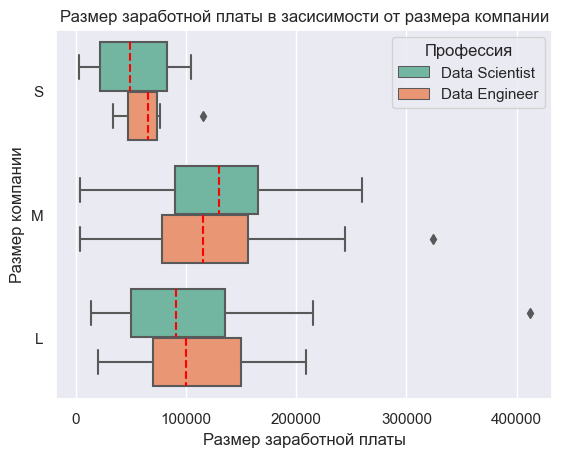

In [28]:
f = sns.boxplot(DS_DE1, 
            x = 'salary_in_usd', 
            y = 'company_size',
            order=["S", "M", "L"],
            orient='h', 
            medianprops={"color": "red", "linestyle": '--'},
            hue="job_title")
            
f.set_title('Размер заработной платы в засисимости от размера компании')

f.set(xlabel='Размер заработной платы', 
      ylabel= 'Размер компании')

f.legend(title="Профессия")
    
plt.show()

"Коробки" в компаниях разного размера имеют разный размер вариации значений, т.о. можем предположить  о наличии статистически значимой разницы в зарплатах Data Scientist и Data Engineer в компаниях разного размера. Но сделать вывод о том, что зарплата одних специалистов (например Data Engineer) выше зарплаты других специалистов (например Data Scientist) в компаниях всех размеров не представляется возможным.

### 4. Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

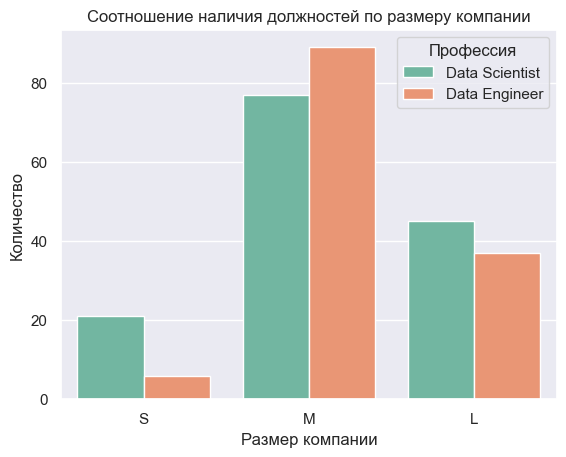

In [29]:
ax = sns.countplot(data=DS_DE1, 
                   x=DS_DE1['company_size'],
                   order = ['S', 'M', 'L'],
                   hue='job_title')
ax.set(xlabel='Размер компании', ylabel='Количество')
ax.legend(title="Профессия")
plt.title('Соотношение наличия должностей по размеру компании')
plt.show()

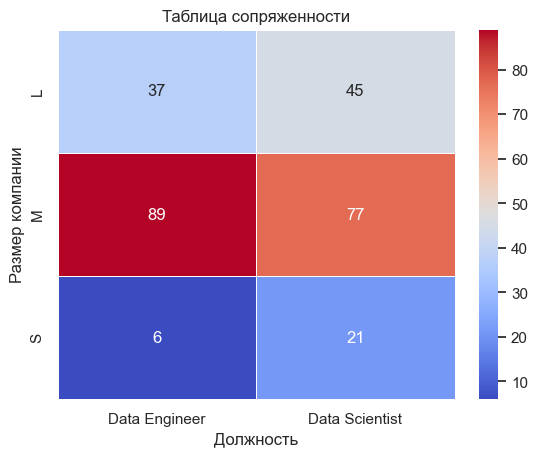

In [30]:
cross_tab = pd.crosstab(index=DS_DE1['company_size'], columns=DS_DE1['job_title'])
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm")
ax.set(xlabel='Должность', ylabel='Размер компании')
plt.title('Таблица сопряженности')
plt.show()

Графически связь между наличием должностей в компании и ее размером не установлена. Т.е. размер компании не влияет на наличие или отсутствие в ней должностей DS и DE.

### 5. Дополнительные исследования

#### 5.1 Существует ли взаимосвязь между размером заработной платы Data Scientist и валютой в которой специалист получает заработную плату.

In [31]:
DS3 = DS.copy()

In [32]:
def get_currency(currency):                          
    
    currency_list = ['USD', 'EUR', 'GBP', 'INR', 'CAD'] # выбираем валюты, в которых получает зп более 5 специалистов
    
    if currency in currency_list:         
        return currency               
    else:  
        return 'other'               
    
DS3['salary_currency'] = DS3['salary_currency'].apply(get_currency).astype('category')

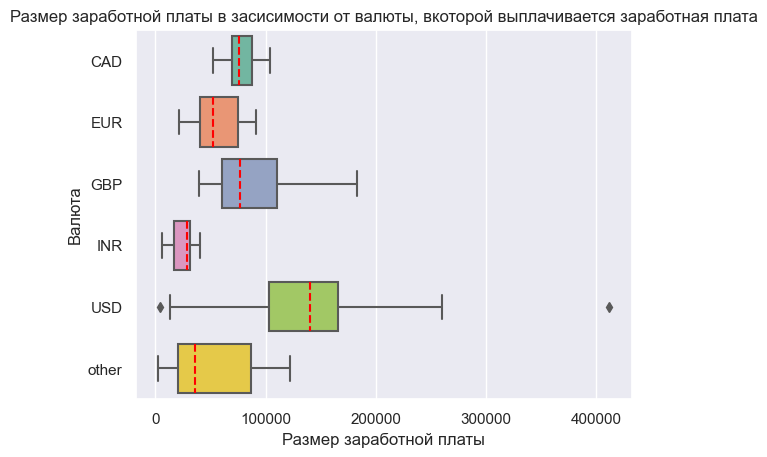

In [33]:
f = sns.boxplot(DS3, 
            x = 'salary_in_usd', 
            y = 'salary_currency',
            orient='h', 
            medianprops={"color": "red", "linestyle": '--'}
            )
            
f.set_title('Размер заработной платы в засисимости от валюты, вкоторой выплачивается заработная плата')

f.set(xlabel='Размер заработной платы', 
      ylabel= 'Валюта')


    
plt.show()

In [34]:
DS_agg = DS3.groupby('salary_currency')['salary_in_usd'].describe().round(2)
print('Размер заработной платы в засисимости от валюты выплаты заработной платы')
DS_agg

Размер заработной платы в засисимости от валюты выплаты заработной платы


,count,mean,std,min,25%,50%,75%,max
salary_currency,,,,,,,,
CAD,5.0,77787.00,19301.65,52396.0,69336.00,75774.0,87738.0,103691.0
EUR,22.0,57591.68,21531.70,21669.0,40486.25,52256.5,75370.0,91237.0
GBP,11.0,88177.36,41393.50,39263.0,60847.00,76958.0,110808.0,183228.0
INR,9.0,23838.33,11758.72,5679.0,16904.00,28399.0,31615.0,40481.0
USD,87.0,139712.76,58519.74,4000.0,103495.00,140000.0,166110.0,412000.0
other,9.0,52822.44,45107.18,2859.0,20171.00,35735.0,86703.0,122346.0


Можно сделать предположение о наличии статистически значимой связи между вылютой, в которой выплачивается заработная плата и размером заработной платы у специалистов Data Scientist.

#### 5.2 Заработная плата каких специалистов была выше в рассматриваемый период?

Сравним заработные платы в 2020, 2021, 2022 гг у специалистов Data Scientist и Data Engineer.

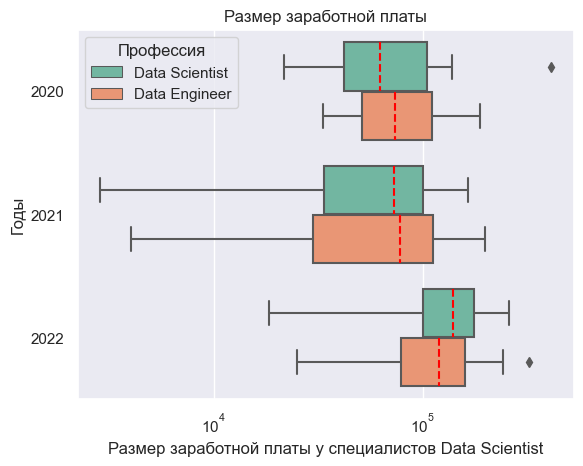

In [35]:
f = sns.boxplot(DS_DE1, 
            x = 'salary_in_usd', 
            y = 'work_year',
            hue = 'job_title',
            orient='h', 
            medianprops={"color": "red", "linestyle": '--'})

f.set_title('Размер заработной платы')
f.set(xscale="log")
f.set(xlabel='Размер заработной платы у специалистов Data Scientist', 
            ylabel= 'Годы')
f.legend(title="Профессия")
plt.show()

Графически можно сделать предположение, что в 2020 и 2021 годах ЗП была выше у Data Engineer,  а в последний год у Data Scientist

#### **Выводы по блоку визуализации данных**:  
Признак заработная плата у специалистов Data Scientist в долларах США имеет распределение близкое к нормальному, что подтверждается визуально и не значительной разницей между средней и медианной заработной платой.  
Ежегодный рост размера заработной платы у специалистов Data Scientist в долларах США отсутствует за рассматриваемый период времени. 
Заработная плата у Data Engineer была выше заработной платы Data Scientist в 2020 - 2021 годах.  

Можно сделать предположение о статистически значимой связи между размером заработной платы у специалистов Data Scientist в долларах США  и следующими признаками:  
* уровень опыта     
* страной нахождения головного офиса    
* страной проживания   
* валютой, в которой выплачивается заработная плата
* объемом удаленной работы  
* размером компании   


Наличие статистически значимой связи между размером заработной платы у специалистов Data Scientist в долларах США  и типом занятости не представляется возможным проверить.

Визуально подтвердились гипотезы о зависимости зарплаты Data Scientist и Data Engineer от размера компании.   

Не подтвердилась гипотеза о зависимости наличия должностей Data Scientist и Data Engineer и размера компании. 

##  Статистический анализ данных 

In [36]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


#### список датасетов для анализа

DS - первоначальный датасет, где отфильтрованы данные потолько по специалистам DS  
DS1  - датасет DS, в котором произведена группировка стран по количественному признаку  
DS2 - датасет DS1, из которого исключены значения США  
DS3 - датасет DS, в котором произведена группировка валют по количественному признаку  
DS_DE1 - первоначальный датасет,  где отфильтрованы данные потолько по специалистам DS и DE, а страны сгруппированы по количественному признаку

In [37]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

### 1. Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

Распределение признака на протяжении 3 лет является временным рядом, что не попадает в категорию рассматриваемых тестов. Проведем попарные одновыборочные тесты.

In [38]:
# зададим уровень с которым будем сравнивать для 2021 года
DS_agg = DS.groupby('work_year')['salary_in_usd'].describe().round(2)
salary_20_m = DS_agg['mean'].iloc[0]
salary_21_m = DS_agg['mean'].iloc[1]

# проверим нормальность распределения зарплат DS в 2021 году
salary_21 = DS[DS['work_year'] == 2021]['salary_in_usd']
salary_22 = DS[DS['work_year'] == 2022]['salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для 2021:')
result = stats.shapiro(salary_21)
decision_normality(result[1])

print('Для 2022:')
result = stats.shapiro(salary_22)
decision_normality(result[1])

Для 2021:
p-value = 0.125
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для 2022:
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


Сформулируем гипотезы:  
*Нулевая гипотеза*: средняя заработная плата DS в текущем году меньше или равна средней заработной плате DS в предыдущем году, рост отсутствует.  H0: m <= m-1  
*Альтернативная гипотеза*: средняя заработная плата DS в текущем году году больше средней заработной плате DS в предыдущем году году, рост отсутствует.  H0: m > m-1 

**Выберем подходящий статистический тест**

* У признака заработная плата количественный тип.
* 1 сравниваемая группа.
* Распределение нормальное.
 
Для проверки нашей гипотезы можно использовать одновыборочный t-критерий.

**Проведём тест**

In [39]:
# проводим тест
_, p = stats.ttest_1samp(salary_21, popmean=salary_20_m, alternative='greater')
print('2021:')
decision_hypothesis(p)

_, p = stats.ttest_1samp(salary_22, popmean=salary_21_m, alternative='greater')
print('2022:')
decision_hypothesis(p)

2021:
p-value = 0.986
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.
2022:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**: поскольку для двух последовательных периодов гипотезы получили различный результат, сделать вывод  о ежегодном росте не представляется возможным. Рост средней заработной платы DS наблюдается только в 2022 году по отношению к 2021 году.

### 2. Соотношение уровня опыта работы и размера заработной платы DS

**Сформулируем нулевую и альтернативные гипотезы**:  
*Нулевая гипотеза*: уровень опыта не влияет на уровень заработной платы. H0: m1 = m2 = m3  
*Альтернативная гипотеза*: уровень опыта влияет на уровень заработной платы. H0: m1 != m2 != m3   

**Проверка на нормальность**  
С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [40]:
# значения ЗП DS в долларах США
salary_MI = DS.loc[DS['experience_level']=='MI', 'salary_in_usd']
salary_EN = DS.loc[DS['experience_level']=='EN', 'salary_in_usd']
salary_SE = DS.loc[DS['experience_level']=='SE', 'salary_in_usd']


# проводим тест Шапиро-Уилка
print('Для Младшего - Среднего уровня:')
result = stats.shapiro(salary_MI)
decision_normality(result[1])

print('Для Начального уровня:')
result = stats.shapiro(salary_EN)
decision_normality(result[1])

print('Для Промежуточного - Старшего уровня:')
result = stats.shapiro(salary_SE)
decision_normality(result[1])

Для Младшего - Среднего уровня:
p-value = 0.178
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для Начального уровня:
p-value = 0.174
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для Промежуточного - Старшего уровня:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

* У признака заработная плата количественный тип.
* 3 сравниваемые группы.
* Группы не зависимы.
* Распределение одной из групп отличается от нормального
 
Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [41]:
_, p = stats.kruskal(salary_MI, salary_EN, salary_SE)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**: уровень опыта влияет на размер заработной платы

### 3. Соотношение типа занятости и размера заработной платы  DS

**Сформулировать нулевую и альтернативные гипотезы можно следующим образом**:  
*Нулевая гипотеза*: тип занятости не влияет на уровень заработной платы. H0: m1 = m2 = m3  
*Альтернативная гипотеза*: тип занятости влияет на уровень заработной платы. H0: m1 != m2 != m3   

Но в связи с недостаточностью наблюдений в 2х выборках, проверить их не представляется возможным без дополнительных данных.

### 4. Соотношение страны, в которой расположен головной офис компании и размера заработной платы DS

**Сформулируем нулевую и альтернативные гипотезы**:  
*Нулевая гипотеза*: страна не влияет на уровень заработной платы. H0: m1 = m2 = m3 ...  = m7  
*Альтернативная гипотеза*: страна влияет на уровень заработной платы. H0: m1 != m2 != m3  ... != m7   

**Проверка на нормальность**  
С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [42]:
#  значения ЗП DS в долларах США
salary_US = DS1.loc[DS1['company_location']=='US', 'salary_in_usd']
salary_GB = DS1.loc[DS1['company_location']=='GB', 'salary_in_usd']
salary_IN = DS1.loc[DS1['company_location']=='IN', 'salary_in_usd']
salary_FR = DS1.loc[DS1['company_location']=='FR', 'salary_in_usd']
salary_DE = DS1.loc[DS1['company_location']=='DE', 'salary_in_usd']
salary_CA = DS1.loc[DS1['company_location']=='CA', 'salary_in_usd']
salary_other = DS1.loc[DS1['company_location']=='other', 'salary_in_usd'] 
    
# проводим тест Шапиро-Уилка
print('Для US:')
result = stats.shapiro(salary_US)
decision_normality(result[1])

print('Для GB:')
result = stats.shapiro(salary_GB)
decision_normality(result[1])

print('Для IN:')
result = stats.shapiro(salary_IN)
decision_normality(result[1])

print('Для FR:')
result = stats.shapiro(salary_FR)
decision_normality(result[1])

print('Для DE:')
result = stats.shapiro(salary_DE)
decision_normality(result[1])

print('Для CA:')
result = stats.shapiro(salary_CA)
decision_normality(result[1])

print('Для other:')
result = stats.shapiro(salary_other)
decision_normality(result[1])

Для US:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для GB:
p-value = 0.277
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для IN:
p-value = 0.761
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для FR:
p-value = 0.128
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для DE:
p-value = 0.148
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для CA:
p-value = 0.997
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для other:
p-value = 0.072
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

* У признака, заработная плата количественны тип.
* 7 сравниваемых групп.
* Группы не зависимы.
* Распределение одной из групп отличается от нормального.
 
Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [43]:
_, p = stats.kruskal(salary_US, salary_GB, salary_IN, salary_FR, salary_DE, salary_CA, salary_other)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


In [44]:
DS2 = DS1[DS1['company_location'] !='US'] # поскольку распределене отличается от нормального только в US, выделим датасет без US и посмотрит будут ли отличаться результаты

**Выберем подходящий статистический тест**

* У признака, заработная плата количественны тип.
* 6 сравниваемых групп.
* Группы не зависимы.
* Группы распределены нормально.
 
Для проверки нашей гипотезы можно использовать Однофакторный дисперсионный анализ (ANOVA).

**Проведём тест**

In [45]:
# зададим новые группы
salary_GB_ = DS2.loc[DS2['employee_residence']=='GB', 'salary_in_usd']
salary_IN_ = DS2.loc[DS2['company_location']=='IN', 'salary_in_usd']
salary_FR_ = DS2.loc[DS2['company_location']=='FR', 'salary_in_usd']
salary_DE_ = DS2.loc[DS2['company_location']=='DE', 'salary_in_usd']
salary_CA_ = DS2.loc[DS2['company_location']=='CA', 'salary_in_usd']
salary_other_ = DS2.loc[DS2['company_location']=='other', 'salary_in_usd']

# проводим тест Левена на равенство дисперсий
print('Тест на равенство дисперсий')
result = stats.levene(salary_GB_, salary_IN_, salary_FR_, salary_DE_, salary_CA_, salary_other_)
p = result[1]
print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, нужно использовать непараметрический тест')
else:
    print('Дисперсии одинаковы, мы можем использовать тест ANOVA')

# проводим тест на сравнение средних в группах
print('\nТест на равенство средних')
_, p = stats.f_oneway(salary_GB_, salary_IN_, salary_FR_, salary_DE_, salary_CA_, salary_other_)

# интерпретируем результат
decision_hypothesis(p)

Тест на равенство дисперсий
p-value = 0.114
Дисперсии одинаковы, мы можем использовать тест ANOVA

Тест на равенство средних
p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**: страна, в которой расположен головной офис компании, влияет на размер заработной платы

### 5. Соотношение страны проживания специалиста и размера заработной платы DS

**Сформулируем нулевую и альтернативные гипотезы**:  
*Нулевая гипотеза*: страна проживания специалиста не влияет на уровень заработной платы. H0: m1 = m2 = m3  ... = m7  
*Альтернативная гипотеза*: страна проживания специалиста влияет на уровень заработной платы. H0: m1 != m2 != m3 ... != m7  

**Проверка на нормальность**  
С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [46]:
#  значения ЗП DS в долларах США
salary_US_e = DS1.loc[DS1['employee_residence']=='US', 'salary_in_usd']
salary_GB_e = DS1.loc[DS1['employee_residence']=='GB', 'salary_in_usd']
salary_IN_e = DS1.loc[DS1['employee_residence']=='IN', 'salary_in_usd']
salary_FR_e = DS1.loc[DS1['employee_residence']=='FR', 'salary_in_usd']
salary_DE_e = DS1.loc[DS1['employee_residence']=='DE', 'salary_in_usd']
salary_CA_e = DS1.loc[DS1['employee_residence']=='CA', 'salary_in_usd']
salary_other_e = DS1.loc[DS1['employee_residence']=='other', 'salary_in_usd'] 
    
# проводим тест Шапиро-Уилка
print('Для US:')
result = stats.shapiro(salary_US_e)
decision_normality(result[1])

print('Для GB:')
result = stats.shapiro(salary_GB_e)
decision_normality(result[1])

print('Для IN:')
result = stats.shapiro(salary_IN_e)
decision_normality(result[1])

print('Для FR:')
result = stats.shapiro(salary_FR_e)
decision_normality(result[1])

print('Для DE:')
result = stats.shapiro(salary_DE_e)
decision_normality(result[1])

print('Для CA:')
result = stats.shapiro(salary_CA_e)
decision_normality(result[1])

print('Для other:')
result = stats.shapiro(salary_other_e)
decision_normality(result[1])

Для US:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для GB:
p-value = 0.277
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для IN:
p-value = 0.661
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для FR:
p-value = 0.444
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для DE:
p-value = 0.170
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для CA:
p-value = 0.792
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для other:
p-value = 0.033
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

* У признака, заработная плата количественны тип.
* 7 сравниваемых групп.
* Группы не зависимы.
* Распределение в двух группах отличается от нормального

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [47]:
_, p = stats.kruskal(salary_US_e, salary_GB_e, salary_IN_e, salary_FR_e, salary_DE_e, salary_CA_e, salary_other_e)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**: страна проживания специалиста влияет на размер его заработной платы

### 6. Соотношение объема удаленной работы и размера заработной платы DS

**Сформулируем нулевую и альтернативные гипотезы**:  
*Нулевая гипотеза*: объем удаленной работы не влияет на уровень заработной платы. H0: m1 = m2 = m3  
*Альтернативная гипотеза*: объем удаленной работы влияет на уровень заработной платы. H0: m1 != m2 != m3   

**Проверка на нормальность**  
С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [48]:
#  значения ЗП DS в долларах США
salary_0 = DS.loc[DS['remote_ratio']== 0, 'salary_in_usd']
salary_50 = DS.loc[DS['remote_ratio']== 50, 'salary_in_usd']
salary_100 = DS.loc[DS['remote_ratio']== 100, 'salary_in_usd']


# проводим тест Шапиро-Уилка
print('Для 0:')
result = stats.shapiro(salary_0)
decision_normality(result[1])

print('Для 50:')
result = stats.shapiro(salary_50)
decision_normality(result[1])

print('Для 100:')
result = stats.shapiro(salary_100)
decision_normality(result[1])

Для 0:
p-value = 0.363
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для 50:
p-value = 0.482
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для 100:
p-value = 0.002
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**
​
* У признака заработная плата количественны тип.
* 3 сравниваемые группы.
* Группы не зависимы.
* Распределение в одной из групп отличается от нормального  
​
Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.  

**Проведём тест**

In [49]:
_, p = stats.kruskal(salary_0, salary_50, salary_100)
decision_hypothesis(p)

p-value = 0.002
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**: объем удаленной работы влияет на размер заработной платы

### 7. Соотношение размера компании и размера заработной платы DS

**Сформулируем нулевую и альтернативные гипотезы**:  
*Нулевая гипотеза*: размер компании не влияет на уровень заработной платы. H0: m1 = m2 = m3  
*Альтернативная гипотеза*: размер компании влияет на уровень заработной платы. H0: m1 != m2 != m3   

**Проверка на нормальность**  
С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [50]:
#  значения ЗП DS в долларах США
salary_S = DS.loc[DS['company_size']=='S', 'salary_in_usd']
salary_M = DS.loc[DS['company_size']=='M', 'salary_in_usd']
salary_L = DS.loc[DS['company_size']=='L', 'salary_in_usd']


# проводим тест Шапиро-Уилка
print('Для S:')
result = stats.shapiro(salary_S)
decision_normality(result[1])

print('Для M:')
result = stats.shapiro(salary_M)
decision_normality(result[1])

print('Для L:')
result = stats.shapiro(salary_L)
decision_normality(result[1])

Для S:
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для M:
p-value = 0.639
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для L:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**
​
* У признака, заработная плата количественны тип, н признака размер компании - категориальный.
* 3 сравниваемыt группы.
* Группы не зависимы.
* Распределение в одной из групп отличается от нормального
​
Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.  
​
**Проведём тест**

In [51]:
_, p = stats.kruskal(salary_S, salary_M, salary_L)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**: размер компании влияет на размер заработной платы  DS

### 8. Как соотносятся зарплаты Data Scientist и Data Engineer в компаниях в зависимости от места нахождения головного офиса компании

**Сформулируем нулевую и альтернативные гипотезы**:  
*Нулевая гипотеза*: уровнь заработной платы Data Scientist (m1) такой же как уровень заработной платы Data Engineer (m2) в компаниях разного размера.   
*Альтернативная гипотеза*: между уровнем заработной платы Data Scientist и Data Engineer и размером компании существует взаимосвязь (признаки зависимы).    

**Проверка на нормальность**  
С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [52]:
#  значения ЗП DS в долларах США
salary_US2 = DS_DE1.loc[DS_DE1['company_location']=='US', 'salary_in_usd']
salary_GB2 = DS_DE1.loc[DS_DE1['company_location']=='GB', 'salary_in_usd']
salary_IN2 = DS_DE1.loc[DS_DE1['company_location']=='IN', 'salary_in_usd']
salary_FR2 = DS_DE1.loc[DS_DE1['company_location']=='FR', 'salary_in_usd']
salary_DE2 = DS_DE1.loc[DS_DE1['company_location']=='DE', 'salary_in_usd']
salary_ES2 = DS_DE1.loc[DS_DE1['company_location']=='ES', 'salary_in_usd']
salary_other2 = DS_DE1.loc[DS_DE1['company_location']=='other', 'salary_in_usd'] 
    
# проводим тест Шапиро-Уилка
print('Для US:')
result = stats.shapiro(salary_US2)
decision_normality(result[1])

print('Для GB:')
result = stats.shapiro(salary_GB2)
decision_normality(result[1])

print('Для IN:')
result = stats.shapiro(salary_IN2)
decision_normality(result[1])

print('Для FR:')
result = stats.shapiro(salary_FR2)
decision_normality(result[1])

print('Для DE:')
result = stats.shapiro(salary_DE2)
decision_normality(result[1])

print('Для ES:')
result = stats.shapiro(salary_ES2)
decision_normality(result[1])

print('Для other:')
result = stats.shapiro(salary_other2)
decision_normality(result[1])

Для US:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для GB:
p-value = 0.015
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для IN:
p-value = 0.830
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для FR:
p-value = 0.413
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для DE:
p-value = 0.335
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для ES:
p-value = 0.348
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для other:
p-value = 0.300
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**
​
* У признака, заработная плата количественны тип.
* 7 сравниваемых групп.
* Группы не зависимы.
* Распределение в двух группах отличается от нормального.

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.  

**Проведём тест**

In [53]:
_, p = stats.kruskal(salary_US2, salary_GB2, salary_IN2, salary_FR2, salary_DE2, salary_ES2, salary_other2)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**: существует зависимость между местом нахождения головного офиса компании и размером заработной платы Data Scientist и Data Engineer, т.е. можно предположить, что работая в одних страннах данные специалисты получают больше, чем специалисты, работающие в других странах и выполняющие тот же функционал.

### 9. Как соотносятся зарплаты Data Scientist и Data Engineer в компаниях в зависимости от размера компании

**Сформулируем нулевую и альтернативные гипотезы**:  
*Нулевая гипотеза*: размер компании не влияет на уровень заработной платы Data Scientist и Data Engineer (признаки не зависимы).   
*Альтернативная гипотеза*: размер компании влияет на уровень заработной платы Data Scientist и Data Engineer (признаки зависимы). 

Категоризирем признак заработной платы.

In [54]:
DS_DE2 = DS_DE1.copy()

In [55]:
def get_salary(salary):
    if salary < 50000:
        return 1
    elif salary >= 50000 & salary < 100000:
        return 2
    elif salary >= 100000 & salary < 150000:
        return 3
    elif salary >= 150000:
        return 4

In [56]:
DS_DE2['salary_interval'] = DS_DE2['salary_in_usd'].apply(get_salary).astype('int')

In [57]:
# составляем таблицу сопряжённости
cross_tab2 = pd.crosstab(DS_DE2['salary_interval'], [DS_DE2['job_title'], DS_DE2['company_size']])
cross_tab2

job_title       Data Engineer        Data Scientist        
company_size                L   M  S              L   M   S
salary_interval                                            
1                           7   8  2             11  10  11
2                          30  81  4             34  67  10

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Уровень заработной платы - категориальный признак.
* 2 сравниваемые группы - уровень зп DS и уровень зп DЕ.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [58]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_tab2)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**: размер компании влияет на уровень заработной платы Data Scientist и Data Engineer (признаки зависимы)

### 10. Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании

**Сформулируем нулевую и альтернативные гипотезы**:  
*Нулевая гипотеза*: между наличием должностей Data Scientist и Data Engineer и размером компании нет взаимосвязи (признаки независимы) 
*Альтернативная гипотеза*: между наличием должностей Data Scientist и Data Engineer и размером компании есть взаимосвязь (признаки зависимы).  

In [59]:
# составляем таблицу сопряжённости
cross_tab = pd.crosstab(index=DS_DE1['company_size'], columns=DS_DE1['job_title'])
cross_tab

job_title,Data Engineer,Data Scientist
company_size,,
L,37,45
M,89,77
S,6,21


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Наличие должностей - бинарный признак.
* Две сравниваемые группы одной выборки.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [60]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_tab)
decision_hypothesis(p)

p-value = 0.008
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**: между наличием должностей Data Scientist и Data Engineer и размером компании есть взаимосвязь (признаки зависимы)

### 11. Существует ли взаимосвязь между размером заработной платы Data Scientist и валютой, в которой специалист получает заработную плату

**Сформулируем нулевую и альтернативные гипотезы**:  
*Нулевая гипотеза*: валюта, в которой специалист получает заработную плату не влияет на уровень заработной платы (признаки не зависимы).   
*Альтернативная гипотеза*: валюта, в которой специалист получает заработную плату влияет на уровень заработной платы (признаки зависимы). 

In [61]:
DS4 = DS1.copy()

In [62]:
def get_salary(salary):                          
    if salary < 50000:         
        return 1               
    elif salary >= 50000 and salary < 100000:  
        return 2 
    elif salary >= 100000 and salary <150000:
        return 3
    else:
        return 4
    
DS4['salary_interval'] = DS4['salary_in_usd'].apply(get_salary).astype('int')

In [63]:
DS4['salary_currency'] = DS4['salary_currency'].apply(get_currency).astype('category')

cross_tab = pd.crosstab(index=DS4['salary_currency'], columns=DS4['salary_interval'])
cross_tab

salary_interval,1,2,3,4
salary_currency,,,,
CAD,0,4,1,0
EUR,10,12,0,0
GBP,2,5,3,1
INR,9,0,0,0
USD,5,11,40,31
other,6,1,2,0


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Валюта - категориальны признак.
* 4 сравниваемые группы одной выборки.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [64]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_tab)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**: валюта, в которой специалист получает заработную плату влияет на уровень заработной платы (признаки зависимы).

### 12. Заработная плата каких специалистов была выше в рассматриваемый период?

**Сформулируем нулевую и альтернативные гипотезы**:  
*Нулевая гипотеза*:заработная плата Data Engineer (m1) больше или равна заработной плате Data Scientist (m2) в 2020, 2021, 2022 годах.   H0: m1 >= m2
*Альтернативная гипотеза*: заработная плата Data Engineer (m1) меньше заработной платs Data Scientist (m2) в 2020, 2021, 2022 годах.   H0: m1 < m2    

**Проверка на нормальность**  
С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [66]:
#  значения ЗП в долларах США
DS_DE_2020 = DS_DE1[DS_DE['work_year'] == 2020]
salary_20_DE = DS_DE_2020.loc[DS_DE_2020['job_title']=='Data Engineer', 'salary_in_usd']
salary_20_DS = DS_DE_2020.loc[DS_DE_2020['job_title']=='Data Scientist', 'salary_in_usd']

DS_DE_2021 = DS_DE1[DS_DE['work_year'] == 2021]
salary_21_DE = DS_DE_2021.loc[DS_DE_2021['job_title']=='Data Engineer', 'salary_in_usd']
salary_21_DS = DS_DE_2021.loc[DS_DE_2021['job_title']=='Data Scientist', 'salary_in_usd']

DS_DE_2022 = DS_DE1[DS_DE['work_year'] == 2022]
salary_22_DE = DS_DE_2022.loc[DS_DE_2022['job_title']=='Data Engineer', 'salary_in_usd']
salary_22_DS = DS_DE_2022.loc[DS_DE_2022['job_title']=='Data Scientist', 'salary_in_usd']


# проводим тест Шапиро-Уилка
print('Для ЗП DE в 2020 году:')
result = stats.shapiro(salary_20_DE)
decision_normality(result[1])

print('Для ЗП DS в 2020 году:')
result = stats.shapiro(salary_20_DS)
decision_normality(result[1])

print('Для ЗП DE в 2021 году:')
result = stats.shapiro(salary_21_DE)
decision_normality(result[1])

print('Для ЗП DS в 2021 году:')
result = stats.shapiro(salary_21_DS)
decision_normality(result[1])

print('Для ЗП DE в 2022 году:')
result = stats.shapiro(salary_22_DE)
decision_normality(result[1])

print('Для ЗП DS в 2022 году:')
result = stats.shapiro(salary_22_DS)
decision_normality(result[1])

Для ЗП DE в 2020 году:
p-value = 0.341
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для ЗП DS в 2020 году:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для ЗП DE в 2021 году:
p-value = 0.121
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для ЗП DS в 2021 году:
p-value = 0.125
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для ЗП DE в 2022 году:
p-value = 0.010
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для ЗП DS в 2022 году:
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящие статистические тесты**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Уровень заработной платы - категориальный признак.
* 2 сравниваемые группы 
* Группы не зависимые
* Не все выборки имеют нормальное распределение
* Выборки не одинаковой длины

Для проверки нашей гипотезы можно использовать: U критерий Манна-Уитни 

**Проведём тесты**

In [67]:
# проводим тест для 2020 года
_, p = stats.mannwhitneyu(salary_20_DE, salary_20_DS, alternative = 'greater')
print('2020 :')
decision_hypothesis(p)

# проводим тест для 2021 года
_, p = stats.mannwhitneyu(salary_21_DE, salary_21_DS, alternative='greater')
print('2021 :')
decision_hypothesis(p)

# проводим тест для 2023 года
_, p = stats.mannwhitneyu(salary_22_DE, salary_22_DS, alternative = 'greater')

print('2022 :')
decision_hypothesis(p)

2020 :
p-value = 0.214
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.
2021 :
p-value = 0.201
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.
2022 :
p-value = 0.923
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**: во всех трех рассматриваемых периодах заработная плата Data Engineer больше или равна заработной плате Data Scientist.

## **Выводы по блоку статистического анализа**:  
*Выводы о размере заработной платы*:
1. Рост средней заработной платы DS наблюдается только в 2022 году по отношению к 2021 году.
2. Во всех трех рассматриваемых периодах заработная плата Data Engineer больше или равна заработной плате Data Scientist.

*Признаки, влияющие на размер заработной платы Data Scientist*:
* уровень опыта  
* страна, в которой расположен головной офис компании 
* страна проживания специалиста   
* объем удаленной работы  
* размер компании  

Установлена зависимость между местом нахождения головного офиса компании и размером заработной платы Data Scientist и Data Engineer, т.е. можно предположить, что работая в одних страннах данные специалисты получают больше, чем специалисты, работающие в других странах и выполняющие тот же функционал.  
 
*Установлена следующие пары зависимых признаков*:
1. размер компании влияет на уровень заработной платы Data Scientist и Data Engineer (признаки зависимы)
2. между наличием должностей Data Scientist и Data Engineer и размером компании есть взаимосвязь (признаки зависимы)
3. валюта, в которой специалист получает заработную плату влияет на уровень заработной платы (признаки зависимы).

